In [1]:
import os
import re
import gc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path

In [2]:
netID = "jsc9862"
ROOT = Path(f"/scratch/{netID}/Explaining_Song_Popularity") # path to project repo

path_to_lyrics_data = ROOT / "song_lyrics.csv" # Genius Song Lyrics dataset 
path_to_spotify_data = ROOT / "spotify.csv" # Spotify Tracks Dataset

spotify_and_genius_path = ROOT / "spotify_and_genius" / "Data Sources" # Spotify and Genius Tracks Dataset
tracks_path = spotify_and_genius_path / "spotify_tracks.csv"
artists_path = spotify_and_genius_path / "spotify_artists.csv"

output_file = ROOT / "merged_partial.csv" # path to outputed merged dataset

spotify_df = pd.read_csv(
    path_to_spotify_data,
    usecols=["track_name", "artists", "track_genre", "popularity"] # keeping these columns only
)
spotify_df["track_name_norm"] = spotify_df["track_name"].str.lower().str.strip() # normalize
spotify_df["artist_name_norm"] = spotify_df["artists"].str.lower().str.strip()
spotify_df["genres"] = spotify_df["track_genre"]

tracks = pd.read_csv(tracks_path, usecols=["artists_id", "name", "popularity"])
artists = pd.read_csv(artists_path, usecols=["id", "name", "genres"])

spotify_genius = tracks.merge( # add artist name to tracks_df for merging
    artists,
    left_on="artists_id",
    right_on="id",
    how="left",
    suffixes=("_track", "_artist")
)

spotify_genius = spotify_genius.rename(columns={
    "name_track": "track_name",
    "name_artist": "artist_name"
})[["track_name", "artist_name", "genres", "popularity"]]

spotify_genius["track_name_norm"] = spotify_genius["track_name"].str.lower().str.strip() # normalize
spotify_genius["artist_name_norm"] = spotify_genius["artist_name"].str.lower().str.strip()

spotify_all = pd.concat([spotify_df, spotify_genius], ignore_index=True) # combine spotify and spotify and genius datasets

spotify_all.drop_duplicates( # remove duplicate songs
    subset=["track_name_norm", "artist_name_norm"],
    inplace=True
)

# explode dataframe for songs with multiple artists (lists songs twice for each artist credited)
spotify_all["artist_list"] = spotify_all["artist_name_norm"].apply(
    lambda x: [a.strip() for a in x.split(';')] if isinstance(x, str) else []
)
spotify_all_exploded = spotify_all.explode("artist_list")

# chunk loading since HPC has bad memory (lyrics dataset is too big)
chunksize = 20_000
if output_file.exists():
    output_file.unlink()

chunk_iter = pd.read_csv(
    path_to_lyrics_data,
    chunksize=chunksize,
    usecols=["title", "artist", "lyrics"]
)

for i, chunk in enumerate(chunk_iter, start=1):
    chunk["title_norm"] = chunk["title"].str.lower().str.strip() # normalize
    chunk["artist_norm"] = chunk["artist"].str.lower().str.strip()

    merged = pd.merge( # merging lyrics onto songs dataset
        spotify_all_exploded,
        chunk,
        left_on=["track_name_norm", "artist_list"],
        right_on=["title_norm", "artist_norm"],
        how="left"
    )

    merged = merged.dropna(subset=["lyrics"])
    merged.to_csv(output_file, mode="a", header=not output_file.exists(), index=False)

    del chunk, merged # delete for memory
    gc.collect()

    if i % 10 == 0:
        print(f"Processed {i} chunks, memory cleared.")

Processed 10 chunks, memory cleared.
Processed 20 chunks, memory cleared.
Processed 30 chunks, memory cleared.
Processed 40 chunks, memory cleared.
Processed 50 chunks, memory cleared.
Processed 60 chunks, memory cleared.
Processed 70 chunks, memory cleared.
Processed 80 chunks, memory cleared.
Processed 90 chunks, memory cleared.
Processed 100 chunks, memory cleared.
Processed 110 chunks, memory cleared.
Processed 120 chunks, memory cleared.
Processed 130 chunks, memory cleared.
Processed 140 chunks, memory cleared.
Processed 150 chunks, memory cleared.
Processed 160 chunks, memory cleared.
Processed 170 chunks, memory cleared.
Processed 180 chunks, memory cleared.
Processed 190 chunks, memory cleared.
Processed 200 chunks, memory cleared.
Processed 210 chunks, memory cleared.
Processed 220 chunks, memory cleared.
Processed 230 chunks, memory cleared.
Processed 240 chunks, memory cleared.
Processed 250 chunks, memory cleared.


In [3]:
netID = "jsc9862"
ROOT = Path(f"/scratch/{netID}/Explaining_Song_Popularity")
output_file = ROOT / "merged_partial.csv"

merged_df = pd.read_csv(output_file)
print("Merged dataframe shape:", merged_df.shape)

print(merged_df.columns)
print(len(merged_df))
print(merged_df['title_norm'].nunique())

Merged dataframe shape: (22858, 14)
Index(['artists', 'track_name', 'popularity', 'track_genre', 'track_name_norm',
       'artist_name_norm', 'genres', 'artist_name', 'artist_list', 'title',
       'artist', 'lyrics', 'title_norm', 'artist_norm'],
      dtype='object')
22858
20181


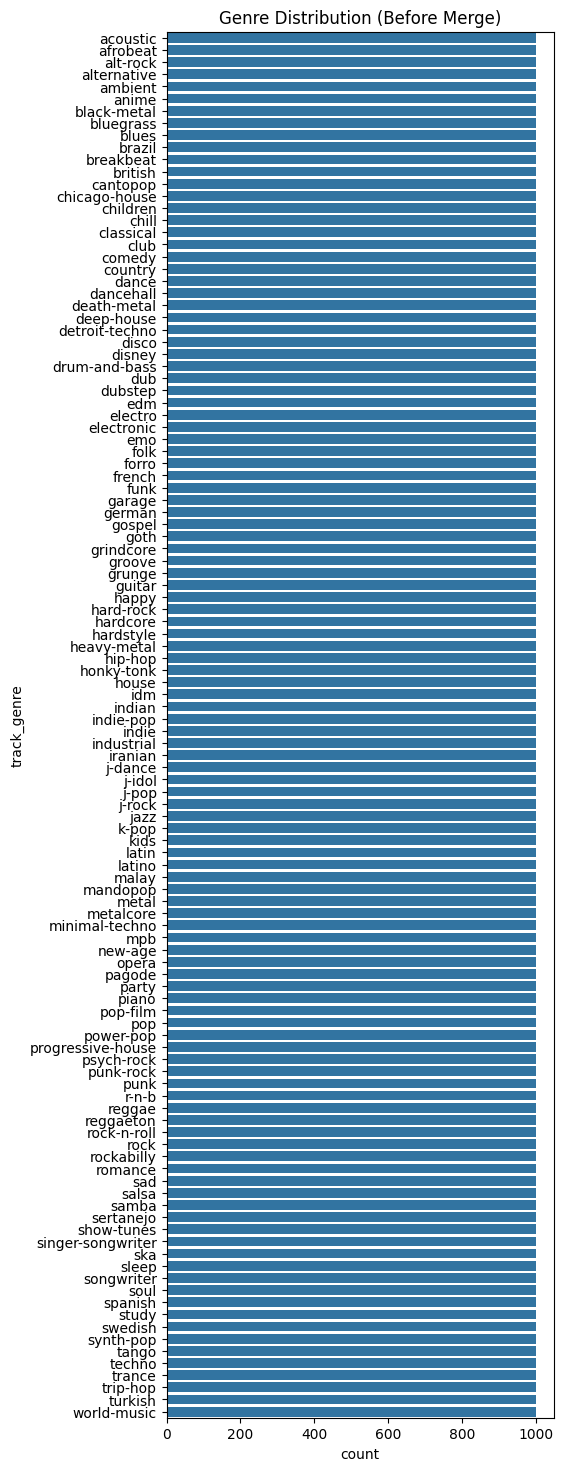

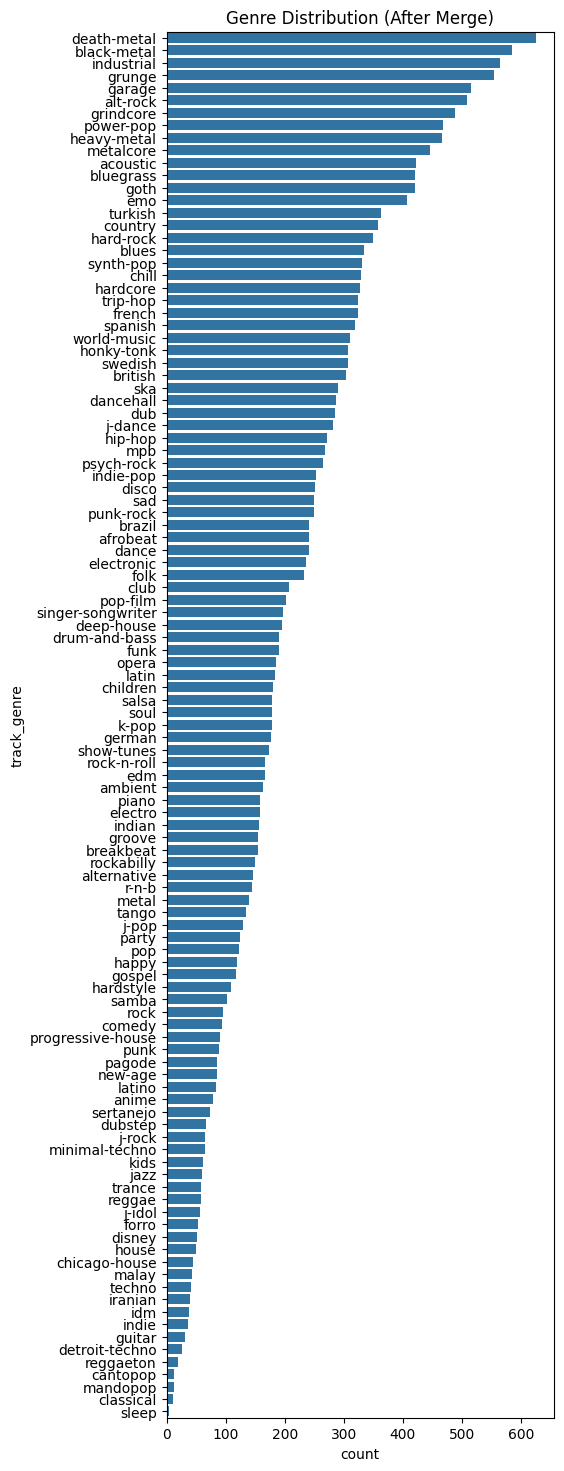

In [4]:
plt.figure(figsize=(5, 18))
sns.countplot(y='track_genre', data=spotify_df, order=spotify_df['track_genre'].value_counts().index)
plt.title("Genre Distribution (Before Merge)")
plt.show()

plt.figure(figsize=(5, 18))
sns.countplot(y='track_genre', data=merged_df, order=merged_df['track_genre'].value_counts().index)
plt.title("Genre Distribution (After Merge)")
plt.show()

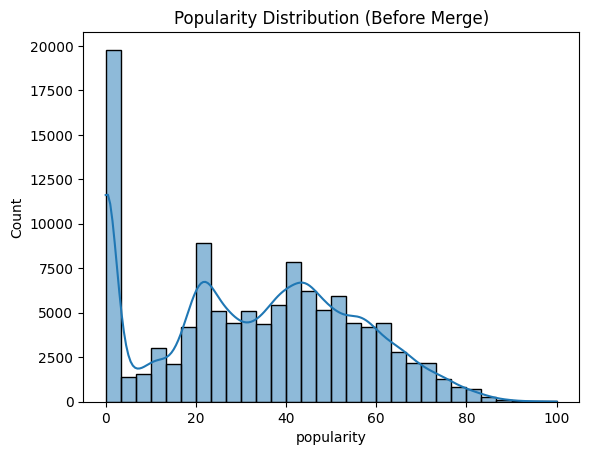

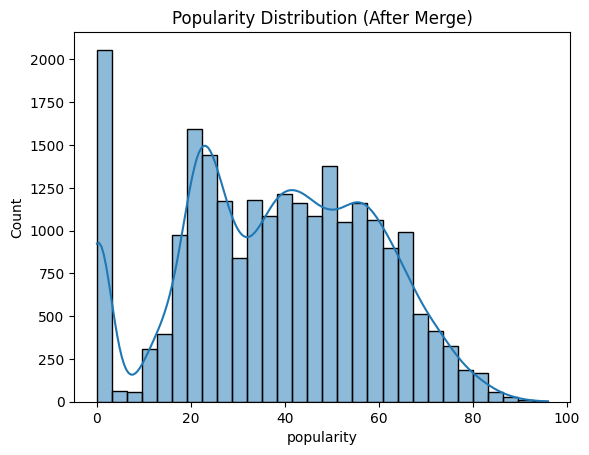

In [5]:
sns.histplot(spotify_df['popularity'], bins=30, kde=True)
plt.title("Popularity Distribution (Before Merge)")
plt.show()

sns.histplot(merged_df['popularity'], bins=30, kde=True)
plt.title("Popularity Distribution (After Merge)")
plt.show()

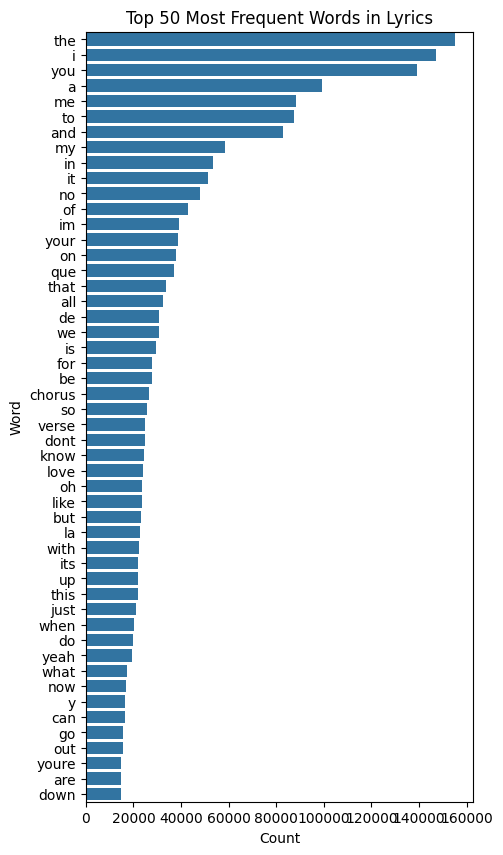

In [6]:
def tokenize(text):
    if pd.isnull(text):
        return []
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    return text.split()

all_words = [word for lyric in merged_df['lyrics'] for word in tokenize(lyric)]

word_counts = Counter(all_words)
common_words = word_counts.most_common(50)
words, counts = zip(*common_words)

plt.figure(figsize=(5, 10))
sns.barplot(x=list(counts), y=list(words))
plt.title("Top 50 Most Frequent Words in Lyrics")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()